In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LSTM, Activation, Flatten, Dropout, SimpleRNN, Bidirectional, Conv1D, GRU
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
#import seaborn as sns
py.init_notebook_mode(connected=True)
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
import fix_yahoo_finance as yf
%matplotlib inline

In [3]:
Stock="APPL"
param = {
    'q': Stock, # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    # Stock exchange symbol on which stock is traded (ex: "NASD")
     'p':'5Y'# Period (Ex: "1Y" = 1 year)
}
# get price data (return pandas dataframe)
#df = get_price_data(param)
  
df = yf.download(Stock,'2008-06-27')
df.to_csv(Stock+'.csv')
df.tail()

[*********************100%***********************]  1 of 1 downloaded


ValueError: zero-size array to reduction operation maximum which has no identity

In [4]:
Stock="APPL"
params = [
    # Dow Jones
    {
        'q': Stock,
        'x': "NASD"
    }
]
period = "10Y"
interval = 60*60 # 30 minutes
# get open, high, low, close, volume time data (return pandas dataframe)
df = get_prices_time_data(params, period, interval)
df.columns = ['Open','High','Low','Close','Volume']
df.to_csv(Stock+'.csv')
df.head()

,Open,High,Low,Close,Volume


In [15]:
data=df
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [16]:
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

In [4]:
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [17]:
predictDates = data.tail(len(data)).index

In [12]:
predictDates

DatetimeIndex(['2003-06-24 13:00:00', '2003-06-25 13:00:00',
               '2003-06-26 13:00:00', '2003-06-27 13:00:00',
               '2003-06-30 13:00:00', '2003-07-01 13:00:00',
               '2003-07-02 13:00:00', '2003-07-03 13:00:00',
               '2003-07-07 13:00:00', '2003-07-08 13:00:00',
               ...
               '2018-06-08 13:00:00', '2018-06-11 13:00:00',
               '2018-06-12 13:00:00', '2018-06-13 13:00:00',
               '2018-06-14 13:00:00', '2018-06-15 13:00:00',
               '2018-06-18 13:00:00', '2018-06-19 13:00:00',
               '2018-06-20 13:00:00', '2018-06-21 13:00:00'],
              dtype='datetime64[ns]', length=3775, freq=None)

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [34]:
#values = data[['Weighted'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = data[['High'] + ['Low']  + ['Open'] + ['Close']]
#values.insert(3,'Volume',data['Volume'])#.rolling(window=50).mean())
#values.insert(4,'M150',data['Close'].rolling(window=50).mean())
#values.insert(5,'MA150',data['Close'].rolling(window=150).mean())
#values.insert(6, 'EMA20', data['Close'].ewm(span=20, adjust=False).mean())
#values.insert(5,'open', data['Open'])
#values=values.iloc[:,1:]
values.dropna(inplace=True)
#values=values.values
values = values.astype('float32')

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [35]:
values.head()

,High,Low,Open,Close
2015-02-02 07:00:00,118.385002,116.639999,118.050003,116.639999
2015-02-02 08:00:00,117.470001,116.080002,116.660004,117.300003
2015-02-02 09:00:00,118.385002,117.290001,117.290001,117.949997
2015-02-02 10:00:00,118.000000,116.959999,117.945000,117.040001
2015-02-02 11:00:00,117.589897,116.650002,117.040001,116.945000


In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [37]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.270168,0.261804,0.269929,0.256846,0.261359,0.256408,0.256593,0.263188
2,0.261359,0.256408,0.256593,0.263188,0.270168,0.268067,0.262637,0.269434
3,0.270168,0.268067,0.262637,0.269434,0.266461,0.264887,0.268922,0.260690
4,0.266461,0.264887,0.268922,0.260690,0.262513,0.261900,0.260239,0.259777
5,0.262513,0.261900,0.260239,0.259777,0.263670,0.264695,0.259375,0.261266


In [38]:
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1   0.270168   0.261804   0.269929   0.256846  0.263188
2   0.261359   0.256408   0.256593   0.263188  0.269434
3   0.270168   0.268067   0.262637   0.269434  0.260690
4   0.266461   0.264887   0.268922   0.260690  0.259777
5   0.262513   0.261900   0.260239   0.259777  0.261266


In [39]:
values = reframed.values
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5417, 1, 4) (5417, 1) (602, 1, 4) (602, 1)


In [41]:
from keras.callbacks import ReduceLROnPlateau
multi_model = Sequential()
multi_model.add(Bidirectional(GRU(300, return_sequences=True),input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Bidirectional(GRU(200,dropout=0.1)))
multi_model.add(Dense(1))
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
multi_model.compile(loss='mse', optimizer=ad)
multi_history = multi_model.fit(train_X, train_y, epochs=30, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=False)

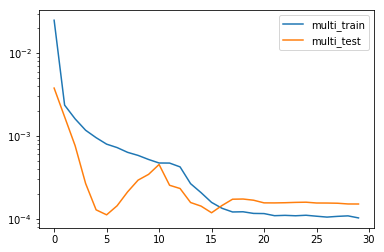

In [42]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

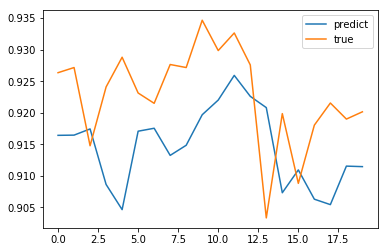

In [43]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat[-20:,:], label='predict')
pyplot.plot(test_y[-20:,:], label='true')
pyplot.legend()
pyplot.show()


In [44]:
diff1=np.concatenate((np.ediff1d(test_y[:-1,0]).reshape(len(test_y[:-1])-1,1),np.ediff1d(yhat[1:,0]).reshape(len(yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff1[:,0],diff1[:,1])
len(mul[mul>=0])/len(mul)

0.7716666666666666

In [33]:
diff2=np.concatenate((np.ediff1d(test_y[:-1,1]).reshape(len(test_y[:-1])-1,1),np.ediff1d(yhat[1:,1]).reshape(len(yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff2[:,0],diff2[:,1])
len(mul[mul>=0])/len(mul)

0.5274542429284526

In [46]:
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, :-1],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-2:]

In [47]:
diff=np.concatenate((np.ediff1d(inv_y[:-1]).reshape(len(inv_y[:-1])-1,1),np.ediff1d(inv_yhat[1:]).reshape(len(inv_yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff[:,0],diff[:,1])
len(mul[mul>=0])/len(mul)

ValueError: cannot reshape array of size 1201 into shape (600,1)

In [96]:
diff2=np.concatenate((np.ediff1d(inv_y[:-1,1]).reshape(len(inv_y[:-1])-1,1),np.ediff1d(inv_yhat[1:,1]).reshape(len(inv_yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff2[:,0],diff2[:,1])
len(mul[mul>=0])/len(mul)

0.864

In [48]:
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

ValueError: y_true and y_pred have different number of output (2!=1)

In [98]:
mul = np.multiply((inv_yhat[:,0]-inv_yhat[:,1]),(inv_y[:,0]-inv_y[:,1]))
len(mul[mul>=0])/len(mul)

0.5

In [26]:
df[-3:]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-27,185.229996,187.279999,184.029999,184.160004,184.160004,25285300
2018-06-28,184.100006,186.210007,183.800003,185.500000,185.500000,17356600
2018-06-29,186.289993,187.184998,182.910004,185.110001,185.110001,20307144


In [27]:
inv_yhat[-3:]

array([[ 183.92752329,  183.74543018],
       [ 184.77426736,  184.62817815],
       [ 184.68365918,  184.49547284]])